In [3]:
!pip install pandas


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
!pip install -U langgraph langchain langchain-tavily python-dotenv dateparser



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

# Set your API keys
# os.environ["OPENAI_API_KEY"] = "sk-..."
# os.environ["TAVILY_API_KEY"] = "sk-..."


True

In [2]:
import json
import dateparser
from typing import Annotated
from typing_extensions import TypedDict

from langchain_tavily import TavilySearch
from langchain.chat_models import init_chat_model, ChatOpenAI
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage


In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    results: list  # store structured job results


In [4]:
# Initialize Tavily
tavily_tool = TavilySearch(max_results=10)
tools = [tavily_tool]

# Initialize LLM
llm = init_chat_model("openai:gpt-4.1")

# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools)


In [5]:
def chatbot(state: State):
    """Main chatbot node: decides what tools to call or responds directly."""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


In [6]:
class BasicToolNode:
    """Runs tools requested by the last AI message."""
    def __init__(self, tools: list):
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in getattr(message, "tool_calls", []):
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


In [7]:
LOG_FILE = "conversation_log.json"
from datetime import datetime 
def append_message_log(sender, message):
    """
    Append a chat message to the conversation log file (JSON) with timestamp.
    """
    try:
        # Load existing conversation
        with open(LOG_FILE, "r") as f:
            conversation = json.load(f)
    except FileNotFoundError:
        conversation = []

    # Append new message
    conversation.append({
        "sender": sender,
        "message": message,
        "timestamp": datetime.now().isoformat()
    })

    # Save back to file
    with open(LOG_FILE, "w") as f:
        json.dump(conversation, f, indent=2)

In [8]:
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import WebBaseLoader
from langchain.prompts import PromptTemplate
import json
import pandas as pd
import os
import dateparser
import re

# CSV file to store job results
CSV_FILE = "job_results.csv"

# Initialize CSV if it doesn't exist
if not os.path.exists(CSV_FILE):
    df = pd.DataFrame(columns=[
        "job_title", "region", "website", "date_posted",
        "years_experience", "visa_sponsorship", "source_url"
    ])
    df.to_csv(CSV_FILE, index=False)


def append_job_to_csv(job: dict):
    """Append a single job to CSV."""
    df = pd.DataFrame([job])
    df.to_csv(CSV_FILE, mode="a", header=False, index=False)
    print(f"[CSV] Job saved: {job.get('job_title', 'N/A')}")


class ScraperNode:
    """Scraper node: fetch URLs, extract structured job info, save to CSV."""

    def __init__(self, user_agent: str = None):
        self.llm = ChatOpenAI(model="gpt-4o-mini")
        self.prompt_template = PromptTemplate(
            input_variables=["text", "url"],
            template="""
Extract job information from the following job posting text.
Return ONLY valid JSON with the keys:
- job_title
- region
- website
- date_posted
- years_experience
- visa_sponsorship (True/False)
- source_url

Job Text:
{text}

Source URL:
{url}
"""
        )
        # self.user_agent = user_agent or "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"

    def __call__(self, inputs: dict):
        messages = inputs.get("messages", [])
        new_results = []

        for msg in messages:
            if hasattr(msg, "content") and isinstance(msg.content, str):
                try:
                    tool_results = json.loads(msg.content)
                except json.JSONDecodeError:
                    print("[ERROR] Failed to parse tool output JSON:", msg.content)
                    continue

                if isinstance(tool_results, list):
                    for result in tool_results:
                        url = result.get("url")
                        if url:
                            try:
                                # Load page
                                loader = WebBaseLoader(url, headers={"User-Agent": self.user_agent})
                                docs = loader.load()
                                if not docs:
                                    print(f"[WARN] No content loaded from {url}")
                                    continue
                                text = docs[0].page_content

                                # Prepare prompt for LLM
                                prompt = self.prompt_template.format(text=text, url=url)
                                response = self.llm.invoke(prompt)
                                print("[LLM RAW OUTPUT]", response[:500])

                                # Try parsing JSON safely
                                try:
                                    job = json.loads(response)
                                except json.JSONDecodeError:
                                    # Extract JSON substring if LLM added extra text
                                    match = re.search(r"\{.*\}", response, re.DOTALL)
                                    if match:
                                        job = json.loads(match.group())
                                    else:
                                        print("[ERROR] Could not parse JSON from LLM response.")
                                        continue

                                # Normalize date
                                if job.get("date_posted"):
                                    dt = dateparser.parse(job["date_posted"])
                                    job["date_posted"] = dt.date().isoformat() if dt else None

                                # Save to CSV
                                append_job_to_csv(job)
                                new_results.append(job)
                            except Exception as e:
                                print(f"[ERROR] Failed processing URL {url}: {e}")
                                continue

        return {"messages": messages, "results": new_results}


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
def route_tools(state: State):
    """Route to ToolNode if the last message has tool calls, else continue to END."""
    if messages := state.get("messages", []):
        ai_message = messages[-1]
        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return "tools"
    return END


In [10]:
graph_builder = StateGraph(State)

# Nodes
graph_builder.add_node("chatbot", chatbot)
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
scraper_node = ScraperNode()
graph_builder.add_node("scraper", scraper_node)

# Conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)

# Graph flow
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "scraper")     # Tavily results -> scraper
graph_builder.add_edge("scraper", "chatbot")   # Back to chatbot
graph = graph_builder.compile()


/var/folders/z6/m56_lfz55xlcdsxdv60z5q340000gn/T/ipykernel_44279/3102686977.py:33: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  self.llm = ChatOpenAI(model="gpt-4o-mini")


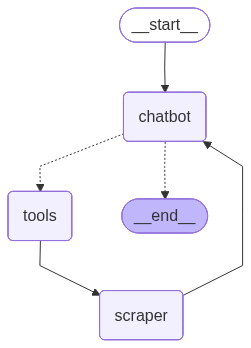

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
import ipywidgets as widgets
from IPython.display import display

out = widgets.Output(layout=widgets.Layout(border='1px solid black', height='400px', overflow='auto'))
display(out)

text_box = widgets.Text(
    placeholder='Type your question...',
    description='User:',
    layout=widgets.Layout(width="80%")
)
display(text_box)

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            assistant_message = value["messages"][-1].content
            with out:
                print("Assistant:", assistant_message)
            append_message_log("Assistant", assistant_message)

def handle_submit(sender):
    user_input = text_box.value.strip()
    text_box.value = ""
    
    if user_input.lower() in ["quit", "exit", "q"]:
        with out:
            print("System: Chat ended.")
        text_box.disabled = True
        append_message_log("System", "Chat ended")
        return
    
    with out:
        print("User:", user_input)
    append_message_log("User", user_input)
    stream_graph_updates(user_input)

text_box.on_submit(handle_submit)


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

Text(value='', description='User:', layout=Layout(width='80%'), placeholder='Type your question...')

/var/folders/z6/m56_lfz55xlcdsxdv60z5q340000gn/T/ipykernel_44279/1387579792.py:38: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  text_box.on_submit(handle_submit)
